# Satellitendaten-Explorer und -Downloader mit SentinelHub

Dieses Notebook zeigt, wie man Datensätze von Sentinel Hub herunterlädt, einer Plattform zur Verwaltung und zum Zugriff auf Satellitenbilder und geospatiale Daten. Mit der robusten [API](https://dataspace.copernicus.eu/analyse/apis) von Sentinel Hub können Benutzer Satellitenbilder abrufen, verarbeiten und analysieren, die auf spezifische Bedürfnisse zugeschnitten sind. Dies ist besonders wertvoll für Anwendungen wie Umweltüberwachung, geospatiale Analysen und Forschung.

**Hauptmerkmale dieses Notebooks:**

* **Zweck**: Zugriff auf Satellitenbilder und deren Download über Sentinel Hub.
* **Anwendungsfälle**: Unterstützung bei der Datenfilterung und der Generierung verschiedener Indizes.

**Informationen zum Datensatz:**
* Python Library: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)
* Author: str.ucture GmbH
* Notebook-Version: 1.1 (Aktualisiert: 21. Januar 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\sentinelhub\download"
images_folder = r".\data\sentinelhub\images"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)

## 2. Filtern und Abrufen von Metadaten für Satellitenbilder

### 2.1 API und Authentifizierung

Die **Sentinel Hub API** ist eine leistungsstarke RESTful-Schnittstelle, die Zugriff auf Satellitenbilder aus verschiedenen Quellen wie **Sentinel**, **Landsat** und anderen Erdbeobachtungsmissionen bietet. Mit dieser API können Benutzer:

* Rohdaten von Satelliten abrufen
* Statistische Analysen durchführen
* Gerenderte Bilder visualisieren

Diese API wird häufig für Anwendungen in Bereichen wie Landwirtschaft, Forstwirtschaft, Umweltüberwachung und mehr verwendet.

#### **a. Authentifizierung mit OAuth2**

Um mit der Sentinel Hub API zu interagieren, ist eine **OAuth2**-Authentifizierung erforderlich. Befolgen Sie diese Schritte, um Ihre Anmeldeinformationen einzurichten und sich zu authentifizieren:

1. **Konto registrieren**  
   - Besuchen Sie das [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) und erstellen Sie ein Konto.
   - Nach der Registrierung melden Sie sich bei Ihrem Konto an.

2. **OAuth-Client erstellen**  
   - Befolgen Sie die [OAuth Client Registrierungsanleitung](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client).
   - Erstellen Sie eine `Client-ID` und ein `Client-Secret` für Ihre Anwendung.

Alternativ gehen Sie zu [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/) > Benutzereinstellungen > Unter OAuth-Clients wählen Sie **+ Erstellen**. > Füllen Sie die Informationen aus und erstellen Sie. Dies gibt Ihnen Ihre `Client-ID` und `Client Secret`.

3. **Verwendung der Anmeldeinformationen für Zugriffstoken**  
   - Verwenden Sie die `Client-ID` und das `Client-Secret`, um Zugriffstoken anzufordern, die zur Authentifizierung und Autorisierung Ihrer API-Anfragen erforderlich sind.
   - Ersetzen Sie die Platzhalter `Client-ID` und `Client-Secret` Werte im folgenden Code durch Ihre tatsächlichen Anmeldeinformationen.

4. **Einmalige Authentifizierung**  
   - Die Authentifizierung ist nur einmal pro Computersystem erforderlich. Nachdem Sie Ihre Anmeldeinformationen eingerichtet und authentifiziert haben, können Sie mit den nächsten Schritten fortfahren, ohne den Prozess zu wiederholen.

#### **b. Schnellzugriffslinks**:

- **Konto registrieren**: [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/)  
- **OAuth-Client einrichten**: [OAuth Client Anleitung](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client)


In [2]:
# # Entkommentieren und führen Sie diese Zelle nur aus, wenn:
# # - Sie diesen Code zum ersten Mal ausführen UND
# # - Sie noch keine Konfiguration erstellt haben.

# from sentinelhub import SHConfig

# # Initialisieren der Sentinel Hub-Konfiguration
# config = SHConfig()

# # Ersetzen Sie die Platzhalter unten mit Ihrer tatsächlichen Client-ID und Client-Secret
# config.sh_client_id = 'your-client-id-here'  # Beispiel: '1234abcd-5678-efgh-ijkl-9876mnopqrst'
# config.sh_client_secret = 'your-client-secret-here'  # Beispiel: 'a1b2c3d4e5f6g7h8i9j0klmnopqrst'

# # Setzen Sie die Basis-URL und Token-URL für das Copernicus Data Space Ecosystem
# config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
# config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# # Speichern Sie die Konfiguration in einer Datei namens "cdse"
# config.save("cdse")

In [3]:
# Import required modules from sentinelhub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    MosaickingOrder,
)

# Load the configuration from the "cdse" file
config = SHConfig("cdse")

# Check if the configuration has loaded properly
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError(
        "The configuration file 'cdse' is missing or incomplete. "
        "Ensure that you have created it with valid 'client ID' and 'client secret'."
    )

### 2.2 Definieren der Abfrageparameter für Daten

Sie können Satellitendaten mit verschiedenen Parametern filtern, um die Ergebnisse basierend auf Ihrem Interessensgebiet und spezifischen Analysebedürfnissen einzugrenzen. Einige der wichtigsten Parameter sind:

1. **Bounding Box Ausdehnungen**: Definieren Sie ein geografisches Interessensgebiet, indem Sie Koordinaten angeben.
2. **Datenbereich**: Filtern Sie die Daten, indem Sie ein Start- und Enddatum angeben.
3. **Wolkenbedeckung**: Beschränken Sie den Datensatz auf Bilder mit einer bestimmten Wolkenbedeckung.
4. **Evaluierungsskripte**: Verwenden Sie benutzerdefinierte Skripte, um bestimmte Bänder zu filtern oder zu verarbeiten, nützlich für fortgeschrittene Anwendungsfälle. (Siehe Abschnitt 3.1 für Details.)


#### 2.2.1. Definieren der Bounding Box Ausdehnungen, Bounding Box und Größe

Die Koordinaten können mit dem Tool <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> ermittelt werden.

*Der BBox Extractor ist ein webbasiertes Tool, das Benutzern hilft, interaktiv eine Bounding Box auszuwählen und deren Koordinaten im WGS84-Format (Breite/Länge) zu generieren. Dies ist besonders nützlich, wenn man mit APIs oder Datensätzen arbeitet, die eine geografische Bereichseingabe erfordern.*


In [4]:
# Definieren Sie die Ausdehnungen der Bounding Box im CRS: WGS84-Format [lon_min, lat_min, lon_max, lat_max]
bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160]  # Bounding Box für Konstanz, Deutschland
resolution = 10  # Die primären Bänder von Sentinel-2 haben eine räumliche Auflösung von 10m

# Erstellen Sie ein BBox-Objekt und berechnen Sie die Dimensionen der Bounding Box basierend auf der Auflösung
aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# Referenzdokumentation für Sentinel-2-Bänder und Auflösung
# Weitere Informationen: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

#### 2.2.2 Definieren des Datumsbereichs für die Suche nach Satellitendaten

In [5]:
import ipywidgets as widgets
import datetime

# Erstellen eines DatePicker-Widgets zur Auswahl des Startdatums
initial_date = widgets.DatePicker(
    description="Startdatum auswählen: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date(2024,1,1)
    )

# Anzeigen des DatePicker-Widgets
display(initial_date)

DatePicker(value=datetime.date(2024, 1, 1), description='Startdatum auswählen: ', step=1, style=DescriptionSty…

In [6]:
# Erstellen eines DatePicker-Widgets zur Auswahl des Enddatums
final_date = widgets.DatePicker(
    description="Enddatum auswählen: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date.today()
    )

# Anzeigen des DatePicker-Widgets
display(final_date)

DatePicker(value=datetime.date(2025, 3, 13), description='Enddatum auswählen: ', step=1, style=DescriptionStyl…

In [7]:
# Stellen Sie sicher, dass das Zeitintervall nur festgelegt wird, wenn beide Datumswerte gültig sind
if initial_date.value and final_date.value:
    # Erstellen eines Tupels für das Zeitintervall mit dem ausgewählten Start- und Enddatum
    time_interval = (str(initial_date.value), str(final_date.value))
    print(f"Zeitintervall erfolgreich festgelegt: {time_interval}")
else:
    # Fehler auslösen, wenn ein Datum fehlt
    raise ValueError("Sowohl das Start- als auch das Enddatum müssen ausgewählt werden, um das Zeitintervall festzulegen.")

Zeitintervall erfolgreich festgelegt: ('2024-01-01', '2025-03-13')


#### 2.2.3 Maximale Wolkenbedeckung in Prozent festlegen

In [8]:
# Erstellen eines BoundedIntText-Widgets zur Angabe des Prozentsatzes der Wolkenbedeckung
cloud_cover_input = widgets.BoundedIntText(
    value=20,
    min=0,
    max=100,
    step=10,
    description="Wolkenbedeckung (%):",
    style={"description_width": "initial"},
    )

# Anzeigen des Eingabe-Widgets für die Wolkenbedeckung
display(cloud_cover_input)


BoundedIntText(value=20, description='Wolkenbedeckung (%):', step=10, style=DescriptionStyle(description_width…

### 2.3 Gefilterten Datensatz mit SentinelHubCatalog abrufen

Der **SentinelHubCatalog** ist ein leistungsstarkes Tool innerhalb der Sentinel Hub API, das Benutzern ermöglicht, nach Metadaten für Satellitenbild-Datensätze zu suchen und diese abzurufen. Es bietet erweiterte Filterfunktionen basierend auf verschiedenen Parametern, wie:

* **Zeitraum**: Filtern nach bestimmten Daten oder Zeitintervallen.
* **Interessensgebiet (AoI)**: Definieren der geografischen Region für den Datensatz.
* **Wolkenbedeckung**: Filtern von Bildern basierend auf dem Prozentsatz der Wolkenbedeckung.
* **Datensammlungen**: Auswahl verschiedener Datensätze (z. B. Sentinel-2, Landsat).

*Dieses Tool vereinfacht den Prozess der Identifizierung und des Abrufs relevanter Bilder, indem es eine effiziente Filterung anhand dieser Kriterien ermöglicht.*

In [9]:
import pandas as pd

# Initialisieren des SentinelHubCatalog mit der Konfiguration
catalog = SentinelHubCatalog(config=config)

# Durchsuchen der Sentinel-2 L2A-Datensammlung mit den definierten Parametern
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    filter=f"eo:cloud_cover <= {cloud_cover_input.value}",
)

# Konvertieren der Suchergebnisse in eine Liste
results = list(search_iterator)
print("Gesamtanzahl der Ergebnisse:", len(results))

# Verarbeitung der Ergebnisse in eine strukturierte Liste von Dictionaries
data = []
for entry in results:
    id = entry['id']
    dt = entry['properties']['datetime']
    date, time = dt.split('T')
    time = time.replace('Z', '')
    cloud_cover = entry['properties']['eo:cloud_cover']
    data.append({
        'Datum': date,
        'Uhrzeit': time,
        'Wolkenbedeckung (%)': cloud_cover,
        'Id': id,
    }),
    
# Konvertieren der Liste in ein Pandas DataFrame und Anzeigen der ersten 8 Zeilen
df = pd.DataFrame(data).sort_values(by='Wolkenbedeckung (%)').reset_index(drop=True)
df.head(8)


Gesamtanzahl der Ergebnisse: 49


Datum       Uhrzeit  Wolkenbedeckung (%)  \
0  2024-09-07  10:27:40.714                 0.00   
1  2025-03-06  10:28:09.432                 0.03   
2  2025-03-06  10:28:13.225                 0.03   
3  2024-09-07  10:27:39.135                 0.04   
4  2024-08-23  10:27:45.974                 0.08   
5  2024-02-03  10:37:36.934                 0.08   
6  2024-12-16  10:27:44.705                 0.09   
7  2024-02-03  10:37:41.626                 0.16   

                                                  Id  
0  S2A_MSIL2A_20240907T102021_N0511_R065_T32TMT_2...  
1  S2C_MSIL2A_20250306T101931_N0511_R065_T32TNT_2...  
2  S2C_MSIL2A_20250306T101931_N0511_R065_T32TMT_2...  
3  S2A_MSIL2A_20240907T102021_N0511_R065_T32TNT_2...  
4  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
5  S2A_MSIL2A_20240203T103231_N0510_R108_T32TNT_2...  
6  S2A_MSIL2A_20241216T102431_N0511_R065_T32TMT_2...  
7  S2A_MSIL2A_20240203T103231_N0510_R108_T32TMT_2...

In [10]:
# Zusätzliche Filterung, um nur Bilder aus den Sommermonaten (Juni, Juli und August) auszuwählen
df['Datum'] = pd.to_datetime(df['Datum'])
filtered_df = df[df['Datum'].dt.month.isin([6, 7, 8])].reset_index(drop=True)
filtered_df.head(3)

Datum       Uhrzeit  Wolkenbedeckung (%)  \
0 2024-08-23  10:27:45.974                 0.08   
1 2024-08-23  10:27:44.048                 0.37   
2 2024-08-11  10:37:42.547                 0.87   

                                                  Id  
0  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
1  S2B_MSIL2A_20240823T101559_N0511_R065_T32TNT_2...  
2  S2A_MSIL2A_20240811T103031_N0511_R108_T32TNT_2...

## 3. Herunterladen und Visualisieren von Satellitendaten

### 3.1 Evaluierungsskripte für die Verarbeitung von Satellitendaten

Evaluierungsskripte **(evalscript)** in der Sentinel Hub API werden verwendet, um die Verarbeitung und Visualisierung von Satellitenbilddaten anzupassen. Mit diesen Skripten können Sie Bänder auswählen, Indizes berechnen (z. B. *NDVI*), benutzerdefinierte Visualisierungen anwenden sowie Daten filtern oder maskieren. Sie werden serverseitig ausgeführt, um verarbeitete Ausgaben wie Bilder oder numerische Werte bereitzustellen, die auf die spezifischen Bedürfnisse des Benutzers zugeschnitten sind. Durch die Verwendung von Evaluierungsskripten können Sie die Datenverarbeitung optimieren und sich auf die präzisen Informationen konzentrieren, die für Fernerkundungsanalysen oder Anwendungen erforderlich sind.

> **Warnung!!: Ändern Sie die Evaluierungsskripte nur, wenn Sie sich Ihrer Änderungen sicher sind.**

Für eine umfassende Sammlung von Evaluierungsskripten und eine detaillierte Anleitung zur Nutzung besuchen Sie die offizielle Dokumentation von Sentinel Hub, [Sentinelhub Evalscript Dokumentation](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). Diese Ressource bietet tiefgehende Erklärungen, Syntaxrichtlinien und praktische Beispiele, die Ihnen helfen, Evaluierungsskripte zur effizienten Verarbeitung von Satellitenbildern zu erstellen und anzupassen.

In [11]:
evalscript_sentinel2_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B01, 
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

### 3.2 Satellitendaten anfordern und Visualisieren

#### 3.2.1 Anforderung der Datensammlung und Abruf des Satellitenbildes mit der geringsten Wolkenbedeckung (Least_CC)

> Hinweis: Die Methode Least_CC hilft, die Datenqualität zu optimieren, insbesondere wenn die Wolkenbedeckung die Klarheit des Bildes beeinträchtigen kann. Stellen Sie sicher, dass Sie dies in Ihrer Anfrage angeben, um die Chancen auf klare Bilder zu maximieren.

In [12]:
# Definieren Sie eine Anfrage, um alle Sentinel-2-Bänder herunterzuladen
request_all_bands = SentinelHubRequest(
    data_folder = download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c",
                service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Anfordern und Abrufen der Daten (ohne sie lokal zu speichern)
all_bands_response = request_all_bands.get_data(save_data=False)

#### 3.2.2 Definieren eine Funktion zur Darstellung der Satellitendaten

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (15, 15),
    show_axis: bool = False,  # Hinzugefügte Option zum Anzeigen der Achsen
    **kwargs: Any
) -> None:
    """
    Hilfsfunktion zum Plotten von RGB-Bildern.

    Parameter:
        image (np.ndarray): Das Bildarray, das geplottet werden soll. Erwartete Form ist (Höhe, Breite, Kanäle).
        factor (float, optional): Skalierungsfaktor zur Anpassung der Bildintensität. Der Standardwert ist 1.0.
        clip_range (Tuple[float, float], optional): Bereich für das Zuschneiden der Bildintensitätswerte.
            Wenn angegeben, werden die Bildwerte auf diesen Bereich begrenzt.
        figsize (Tuple[float, float], optional): Größe der Abbildung in Zoll. Der Standardwert ist (15, 15).
        show_axis (bool, optional): Ob die Achsenmarkierungen angezeigt werden sollen. Der Standardwert ist False.
        **kwargs (Any): Weitere Schlüsselwortargumente, die an plt.imshow übergeben werden.

    Rückgabewert:
        None: Die Funktion zeigt das Bild mit matplotlib an.
    """
    # Erstellen einer Figur und Achse zum Plotten
    fig, ax = plt.subplots(figsize=figsize)
    
    # Anwendung der Skalierung und optionales Zuschneiden des Bildes
    image_to_display = np.clip(image * factor, *clip_range) if clip_range is not None else image * factor
    
    # Bild anzeigen
    ax.imshow(image_to_display, **kwargs)
    
    # Bedingtes Entfernen der Achsenmarkierungen für eine sauberere Bildanzeige
    if not show_axis:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

### 3.2.3 Visualisierung des Satellitenbildes in Echtfarbe (RGB)

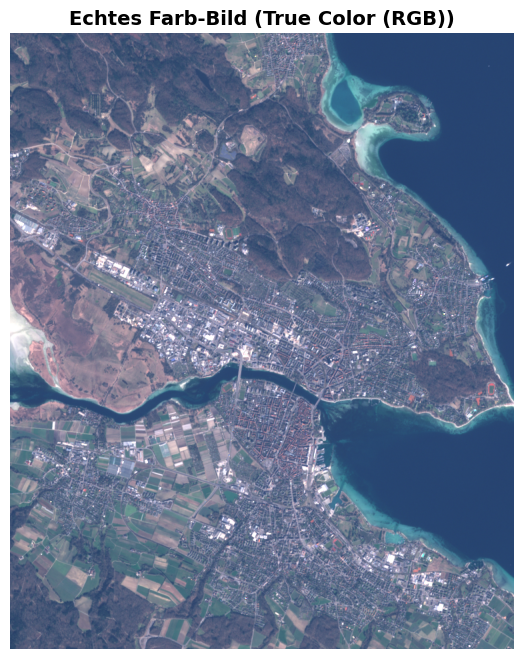

In [14]:
# Holen Sie sich das erste Bild aus all_bands_response
image = all_bands_response[0]

# Berechnen Sie den Intensitätsbereich für Skalierung und Zuschneiden
min_val = np.percentile(image, 2) # 2. Perzentil für die untere Grenze
max_val = np.percentile(image, 98) # 98. Perzentil für die obere Grenze

# Berechnen Sie den Skalierungsfaktor basierend auf dem maximalen Wert
factor = 1.0 / max_val

# Wenden Sie einen Multiplikator an, um die Intensität weiter anzupassen
factor_multiplier = 1.4

# Plotten Sie das Bild in echten Farben (RGB) unter Verwendung des berechneten Skalierungsfaktors
plot_image(
    image[:, :, [3, 2, 1]], # Bandindizes für Rot, Grün und Blau (B04, B03, B02)
    factor=factor * factor_multiplier, # Wenden Sie den Faktor und den Multiplikator an, um die Intensität zu skalieren
    clip_range=(0, 1), # Begrenzen Sie die Intensität auf den Bereich [0, 1]
    figsize=(8, 8)
)

# Setzen Sie den Titel für das Diagramm
plt.title("Echtes Farb-Bild (True Color (RGB))", fontsize=14, fontweight='bold')
plt.show()

Manchmal können die Anforderungsparameter—wie der Zeitraum und `mosaicking_order`—zu minderwertigen oder unerwünschten Mosaik-Satellitendaten führen. In solchen Fällen kann es notwendig sein, das Zeitintervall manuell anzupassen, um sicherzustellen, dass die gewünschten Satellitenbilder abgerufen werden. Weitere Details dazu, wie man den Zeitraum ändert, finden Sie in Abschnitt 2.3.

Zusätzlich ist die Möglichkeit, direkt auf Satellitendaten anhand einer bestimmten Bild-ID zuzugreifen, eine wertvolle Funktion mit großem Potenzial. Diese Funktion sollte weiter untersucht werden, um ihre Möglichkeiten vollständig zu verstehen und effektiv umzusetzen.


In [15]:
# Beispiel: Anfordern von Daten für die angegebenen Parameter in der Tabelle "df"

# Definieren des Zeitintervalls (ändern je nach spezifischen Anforderungen)
time_interval = '2024-08-23' # Passen Sie diesen Wert an, um nach dem gewünschten Zeitraum zu filtern

# Anfordern von Satellitendaten basierend auf den bereitgestellten Parametern
request_all_bands = SentinelHubRequest(
    data_folder=download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Abrufen der Satellitendaten
all_bands_response_v2 = request_all_bands.get_data(save_data=False)

# Ändern Sie save_data=True, um die Daten lokal zu speichern
# all_bands_response_v3 = request_all_bands.get_data(save_data=True)

### 3.2.4 Visualisierung des aktualisierten Satellitenbildes in Echtfarbe (RGB)

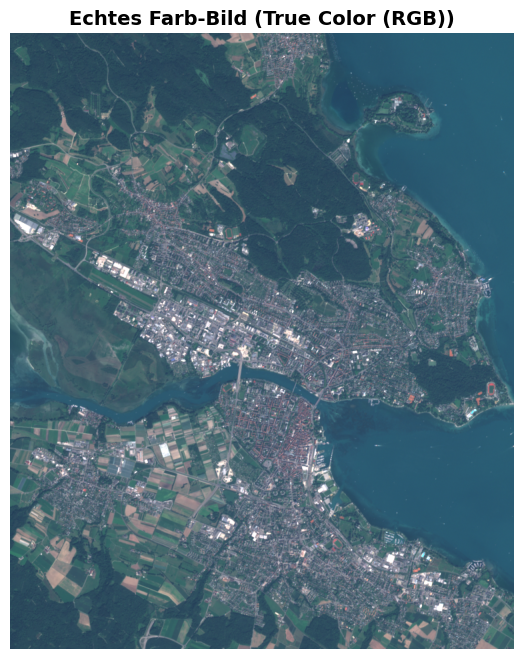

In [16]:
# Abrufen des ersten Bildes aus den Antwortdaten
image = all_bands_response_v2[0]

# Berechnung des Intensitätsbereichs, Skalierungsfaktors und Anpassung der Gesamthelligkeit
min_val = np.percentile(image, 2)
max_val = np.percentile(image, 98)
factor = 1.0 / max_val
factor_multiplier = 1.6

# Plotten des Bildes in echten Farben (RGB) unter Verwendung des angegebenen Skalierungs- und Clipping-Bereichs
plot_image(
    image[:, :, [3, 2, 1]],
    factor=factor * factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Festlegen des Titels für das Diagramm
plt.title("Echtes Farb-Bild (True Color (RGB))", fontsize=14, fontweight='bold')
plt.show()

## 4. Speichern das Bild als GeoTIFF-Raster und PNG

Eine effektive Möglichkeit, Sentinel-2-Datensätze zu visualisieren und die Integrität zu bewahren, besteht darin, sie lokal als GeoTIFF-Datei zu speichern. GeoTIFF ist ein weit verbreitetes Format, das nicht nur die Bilddaten, sondern auch wichtige geospatiale Metadaten wie geografische Koordinaten, Projektionsinformationen und andere Eigenschaften beibehält. Dies macht es ideal für weitere Analysen in GIS-Software wie QGIS, ArcGIS oder anderen geospatialen Tools.

Das Speichern Ihres Bildes in diesem Format stellt sicher, dass Sie die Bilddaten einfach laden, manipulieren und visualisieren können, während die räumliche Referenz beibehalten wird.

In [17]:
import rasterio
from rasterio.transform import from_bounds
from PIL import Image

# Definieren Sie die Form und die Transformationsparameter basierend auf den Bildabmessungen
höhe, breite, bänder = image.shape
transform = from_bounds(*bbox_wgs84, width=breite, height=höhe)

# Extrahieren Sie die RGB-Bänder (Rot, Grün, Blau) und verarbeiten Sie das Bild vor
rgb_image = image[:, :, [3, 2, 1]]
clipped_image = np.clip(rgb_image * factor * factor_multiplier, 0, 1)
uint8_image = (clipped_image * 255).astype(np.uint8)

# Definieren Sie die Pfade zum Speichern der Bilder
temp_tif = os.path.join(images_folder, f"sentinel2_all_bands_{time_interval}.tif")
temp_png = os.path.join(images_folder, f"sentinel2_rgb_{time_interval}.png")

# Stellen Sie sicher, dass der Download-Ordner existiert
os.makedirs(images_folder, exist_ok=True)

# Speichern Sie das Bild als GeoTIFF, wenn es noch nicht existiert
if not os.path.isfile(temp_tif):
    with rasterio.open(
        temp_tif,
        "w",
        driver="GTiff",
        height=höhe,
        width=breite,
        count=3, # Nur 3 Bänder für RGB
        dtype=uint8_image.dtype,
        crs="EPSG:4326", # WGS84-Koordinatenreferenzsystem
        transform=transform,
    ) as dst:
        for i in range(3): # Schleife durch die RGB-Bänder
            dst.write(uint8_image[:, :, i], i + 1)
    print(f"GeoTIFF gespeichert unter: {temp_tif}")
else:
    print(f"GeoTIFF-Datei existiert bereits unter: {temp_tif}")
    
# Speichern Sie das Bild als PNG-Datei
if not os.path.isfile(temp_png):
    # Konvertieren Sie das RGB-Array in das PIL Image-Format und speichern Sie es als PNG
    pil_image = Image.fromarray(uint8_image, mode="RGB")
    pil_image.save(temp_png)
    print(f"PNG gespeichert unter: {temp_png}")
else:
    print(f"PNG-Datei existiert bereits unter: {temp_png}")

GeoTIFF-Datei existiert bereits unter: .\data\sentinelhub\images\sentinel2_all_bands_2024-08-23.tif
PNG-Datei existiert bereits unter: .\data\sentinelhub\images\sentinel2_rgb_2024-08-23.png


## 5. Visualisieren True-Color-Raster mit einer interaktiven Karte

Sobald das True-Color-Raster als GeoTIFF-Datei gespeichert wurde, kann es einfach mit Folium visualisiert werden.


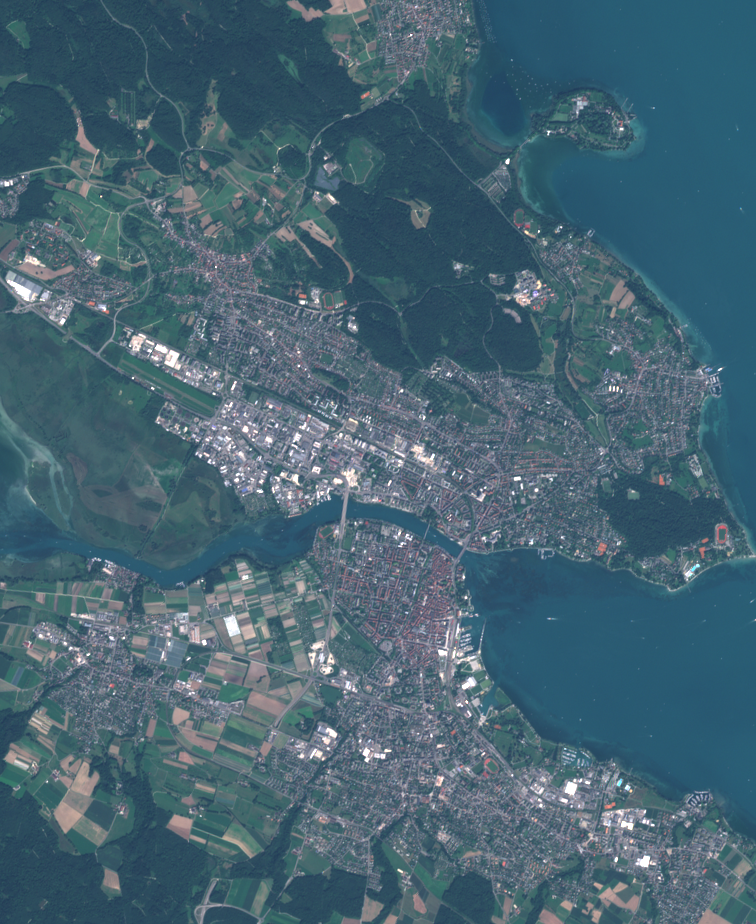

In [18]:
import folium
from folium.plugins import MiniMap, Fullscreen

# Erstellen Sie eine Folium-Karte, die um die Bounding Box zentriert ist
m = folium.Map(
    location=[(bbox_wgs84[1] + bbox_wgs84[3])/2, (bbox_wgs84[0] + bbox_wgs84[2])/2],
    zoom_start=12,
    scrollWheelZoom=False
    )

# Definieren Sie die Grenzen des Bildes in Breitengrad/Längengrad
bounds_latlon = [[bbox_wgs84[1], bbox_wgs84[0]], [bbox_wgs84[3], bbox_wgs84[2]]]

# Fügen Sie eine Rasterüberlagerung für das gespeicherte PNG-Bild hinzu (alternativ kann auch GeoTIFF verwendet werden)
temp_png_filename = (os.path.basename(temp_png).split(".")[0])
folium.raster_layers.ImageOverlay(
    name=f"{temp_png_filename}",
    image=temp_png,
    bounds=bounds_latlon,
    opacity=1.0,
).add_to(m)

# Fügen Sie eine Layer-Steuerung hinzu (zum Umschalten zwischen den Layern)
folium.LayerControl().add_to(m)

# Fügen Sie MiniMap und Fullscreen-Steuerelemente hinzu
MiniMap(toggle_display=True, minimized=True).add_to(m)
Fullscreen().add_to(m)

# Zeigen Sie die Karte an
m

## 6. Analyse und Visualisierung von Satellitenbildern

### 6.1 Falschfarbenkomposit: Vegetationsanalyse

Falschfarbenkomposits heben spezifische Merkmale in Satellitenbildern hervor, wie z. B. Vegetation, Gewässer und städtische Gebiete, indem verschiedenen Farben unsichtbare spektrale Bänder zugewiesen werden. Diese Methode ist besonders nützlich für die Analyse der Landnutzung, der Vegetationsgesundheit (mit Bändern wie NIR und Red Edge) und anderer Umweltfaktoren.

Mehr über benutzerdefinierte Komposit-Skripte und deren Anwendungsfälle können Sie im offiziellen [Sentinel Hub Custom Scripts Repository](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/) erfahren.


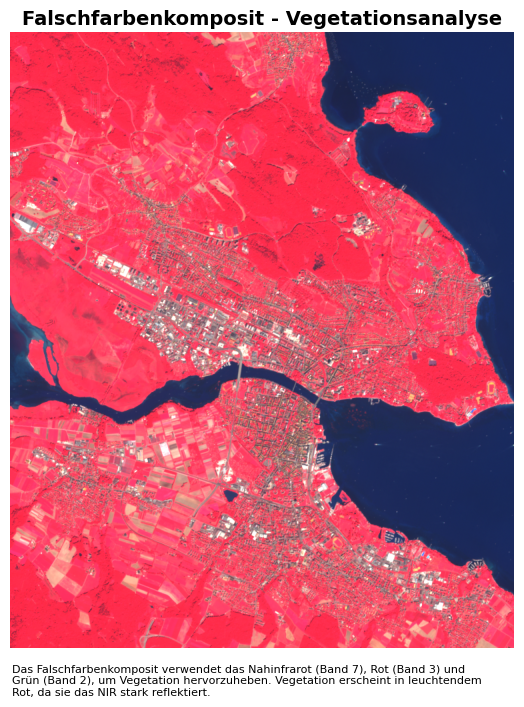

In [19]:
import textwrap

# Erstellen Sie eine Falschfarbenkompositdarstellung unter Verwendung spezifischer Bänder: 
# Band 7 (NIR), Band 3 (Rot), Band 2 (Grün) für die Vegetationsanalyse
# Dies wird oft verwendet, um Vegetation hervorzuheben, da das NIR-Band (Nahinfrarot) die Vegetation stark reflektiert.
plot_image(
    image[:, :, [7, 3, 2]], # NIR (Band 7), Rot (Band 3), Grün (Band 2)
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Setzen Sie den Titel für das Diagramm
plt.title("Falschfarbenkomposit - Vegetationsanalyse", fontsize=14, fontweight='bold')

# Beschreibungstext definieren
text = (
    "Das Falschfarbenkomposit verwendet das Nahinfrarot (Band 7), Rot (Band 3) und Grün (Band 2), um Vegetation hervorzuheben. Vegetation erscheint in leuchtendem Rot, da sie das NIR stark reflektiert."
)
wrapped_text = textwrap.fill(text, width=80) 

# Beschreibung hinzufügen
plt.figtext(
    0.2,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    # wrap=True,
    backgroundcolor='w',
)

# Zeigen Sie das Diagramm an
plt.show()

### 6.2 Fernerkundungsindizes (Remote Sensing Indices)

Fernerkundungsindizes wie der Normalized Difference Vegetation Index (NDVI), Normalized Difference Water Index (NDWI) und andere werden häufig verwendet, um verschiedene Umweltfaktoren wie die Gesundheit der Vegetation, Gewässer und die Landbedeckung zu analysieren.

Weitere Informationen zur Berechnung und Nutzung dieser Indizes finden Sie im offiziellen [Sentinel Hub Custom Scripts Repositiry](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/#popular-rgb-composites)

#### 6.2.1 Normalized Difference Vegetation Index (NDVI)

Der Normalized Difference Vegetation Index (NDVI) misst die Pflanzen-gesundheit und Biomasse. Er wird häufig verwendet, um das Wachstum und die Gesundheit der Vegetation zu überwachen sowie Gebiete mit Stress oder Schäden zu identifizieren.

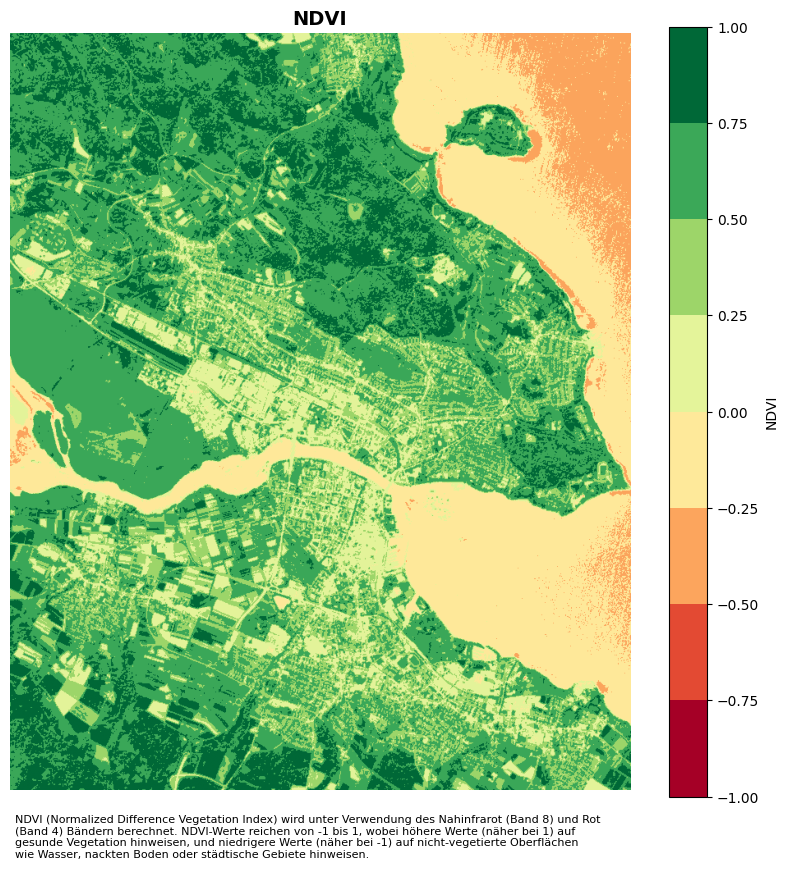

In [20]:
# Extrahieren Sie die NIR (Band 8) und Rot (Band 4) Bänder aus den Satellitendaten
nir = all_bands_response_v2[0][:, :, 7]  # Band 8 (NIR)
rot = all_bands_response_v2[0][:, :, 3]  # Band 4 (Rot)

# Berechnen Sie den NDVI (Fügen Sie eine kleine Zahl zum Nenner hinzu, um Division durch null zu vermeiden)
ndvi = (nir - rot) / (nir + rot + 1e-10)

# NDVI plotten
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn', 8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)

# Fügen Sie eine Farbskala hinzu
plt.colorbar(label='NDVI')

# Setzen Sie den Titel für das Diagramm
plt.title('NDVI', fontsize=14, fontweight='bold')

# Definieren Sie den Beschreibungstext
text = (
    "NDVI (Normalized Difference Vegetation Index) wird unter Verwendung des Nahinfrarot (Band 8) und Rot (Band 4) Bändern berechnet. "
    "NDVI-Werte reichen von -1 bis 1, wobei höhere Werte (näher bei 1) auf gesunde Vegetation hinweisen, und niedrigere Werte (näher bei -1) "
    "auf nicht-vegetierte Oberflächen wie Wasser, nackten Boden oder städtische Gebiete hinweisen."
)
wrapped_text = textwrap.fill(text, width=100)

# Beschreibung hinzufügen
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Entfernen Sie die Achsenmarkierungen für eine sauberere Anzeige
plt.axis('off')

# Zeigen Sie das Diagramm an
plt.show()


#### 6.2.2 Normalized Difference Moisture Index (NDMI)

Der Normalized Difference Moisture Index (NDMI) ist ein wichtiger Indikator zur Überwachung des Wassergehalts von Pflanzen. Er hilft dabei, die Pflanzen gesund zu bewerten, Trockenstress zu erkennen und die Effizienz der Bewässerung zu beurteilen.

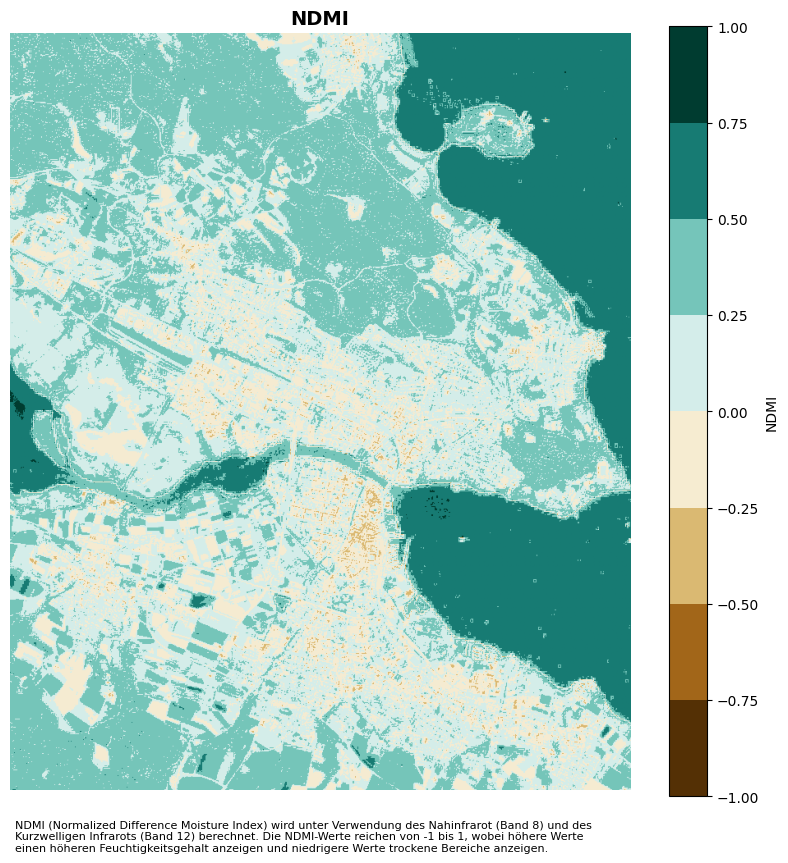

In [21]:
# Extrahiere die NIR (Band 8) und SWIR (Band 12) Bänder aus den Satellitendaten
nir = all_bands_response_v2[0][:, :, 7]  # Band 8 (NIR)
swir = all_bands_response_v2[0][:, :, 11]  # Band 12 (SWIR)

# Berechne den NDMI (Füge eine kleine Zahl zum Nenner hinzu, um eine Division durch null zu vermeiden)
ndmi = (nir - swir) / (nir + swir + 1e-10)

# Plotte den NDMI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8)  # Angepasste Farbkarte für NDMI
plt.imshow(ndmi, cmap=cmap, vmin=-1, vmax=1)

# Füge eine Farbskala hinzu
plt.colorbar(label='NDMI')

# Setze den Titel für das Diagramm
plt.title('NDMI', fontsize=14, fontweight='bold')

# Definiere die Textbeschreibung
text = (
    "NDMI (Normalized Difference Moisture Index) wird unter Verwendung des Nahinfrarot (Band 8) und des Kurzwelligen Infrarots (Band 12) berechnet. "
    "Die NDMI-Werte reichen von -1 bis 1, wobei höhere Werte einen höheren Feuchtigkeitsgehalt anzeigen und niedrigere Werte trockene Bereiche anzeigen."
)
wrapped_text = textwrap.fill(text, width=100)

# Füge die Beschreibung hinzu
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Entferne die Achsenmarkierungen für eine sauberere Anzeige
plt.axis('off')

# Zeige das Diagramm an
plt.show()

#### 6.2.3 Oberflächenalbedo

Albedo ist ein Maß für die Reflektivität einer Oberfläche, das angibt, wie viel Sonnenlicht von einer Oberfläche reflektiert wird im Vergleich dazu, wie viel absorbiert wird. Es ist entscheidend für das Verständnis des Energiehaushalts der Oberfläche, der Wärmeverteilung und der Eigenschaften der Landbedeckung. In der Fernerkundung wird Albedo häufig verwendet, um Veränderungen in den Oberflächenmerkmalen wie Schneebedeckung, Vegetation oder Urbanisierung zu untersuchen.

Albedo-Werte reichen von 0 (keine Reflektion, vollständige Absorption) bis 1 (vollständige Reflektion), wobei ein höheres Albedo reflektierendere Oberflächen (wie Schnee oder Eis) und ein niedrigeres Albedo dunklere Oberflächen (wie Wälder oder Ozeane) anzeigt.

Regerenz: [Albedo-Retrieval von Sentinel-2](https://doi.org/10.1109/LGRS.2020.2967085)

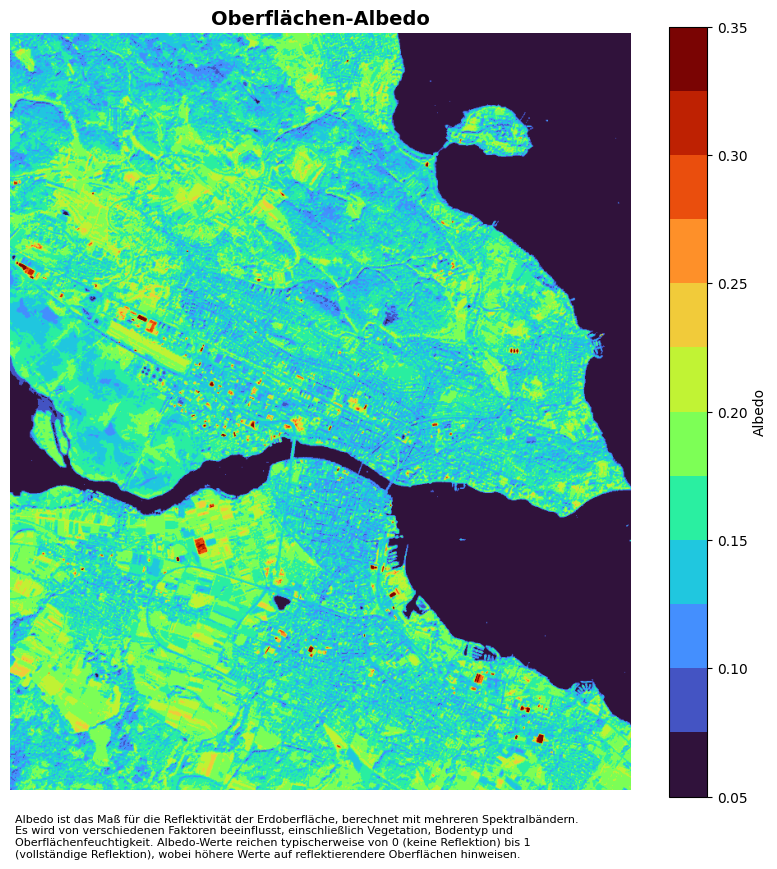

In [22]:
# Extrahiere die Bänder und konvertiere DN in Reflektivität (DN = 10000 * REFLEKTANZ)
B02 = all_bands_response_v2[0][:, :, 1] / 10000.0  # Blau
B03 = all_bands_response_v2[0][:, :, 2] / 10000.0  # Grün
B04 = all_bands_response_v2[0][:, :, 3] / 10000.0  # Rot
B08 = all_bands_response_v2[0][:, :, 7] / 10000.0  # NIR
B11 = all_bands_response_v2[0][:, :, 11] / 10000.0 # SWIR1
B12 = all_bands_response_v2[0][:, :, 12] / 10000.0 # SWIR2

# Berechne Albedo unter Verwendung der Gewichtungen für jedes Band
albedo = (B02 * 0.2266) + (B03 * 0.1236) + (B04 * 0.1573) + \
         (B08 * 0.3417) + (B11 * 0.1170) + (B12 * 0.0338)

# Setze den Albedo-Bereich für die Visualisierung
vmin = 0.05
vmax = 0.35
interval = 0.025

# Plotte das Albedo
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('turbo', int((vmax-vmin)/interval)+1)
plt.imshow(albedo, cmap=cmap, vmin=vmin, vmax=vmax)

# Füge eine Farbskala hinzu
plt.colorbar(label='Albedo')

# Setze den Titel für das Diagramm
plt.title('Oberflächen-Albedo', fontsize=14, fontweight='bold')

# Definiere die Textbeschreibung
text = (
    "Albedo ist das Maß für die Reflektivität der Erdoberfläche, berechnet mit mehreren Spektralbändern. "
    "Es wird von verschiedenen Faktoren beeinflusst, einschließlich Vegetation, Bodentyp und Oberflächenfeuchtigkeit. Albedo-Werte reichen typischerweise "
    "von 0 (keine Reflektion) bis 1 (vollständige Reflektion), wobei höhere Werte auf reflektierendere Oberflächen hinweisen."
)
wrapped_text = textwrap.fill(text, width=100)

# Füge die Beschreibung hinzu
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Entferne Achsenmarkierungen für eine sauberere Anzeige
plt.axis('off')

# Zeige das Diagramm an
plt.show()

## 7. Ergänzungen

In der Fernerkundungsanalyse können verschiedene ergänzende Indizes oder Techniken angewendet werden, um aussagekräftige Informationen aus Satellitenbildern zu extrahieren. Diese Indizes können primäre Analysen (wie Albedo oder NDVI) ergänzen, um Einblicke in die Landbedeckung, die Gesundheit der Vegetation, den Wasserstress und andere Umweltparameter zu bieten.

Zusätzliche Indizes finden Sie in der [Sentinel-2 Index-Datenbank](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/)

Für ein besseres Verständnis der Sentinel-2-Bandmerkmale können Sie auf die folgende Quelle zugreifen, um detailliertere Informationen zu erhalten: [Sentinel-2 Bandmerkmale](https://www.researchgate.net/figure/Sentinel-2-band-characteristics_tbl1_314119510)

In [23]:
# Daten für Sentinel-2 Bänder
data = {
    "Bandname": ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    "Wellenlänge (nm)": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1375, 1610, 2190],
    "Auflösung (m)": [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20],
    "Beschreibung": [
        "Aerosol",
        "Blue",
        "Green",
        "Red",
        "Red Edge 1",
        "Red Edge 2",
        "Red Edge 3",
        "Near Infrared (NIR)",
        "Narrow NIR",
        "Water vapor",
        "Cirrus",
        "Shortwave Infrared (SWIR) - 1",
        "Shortwave Infrared (SWIR) - 2"
    ],
    "Alternative Beschreibung": [
        "Coastal aerosol",
        "Blue",
        "Green",
        "Red",
        "Vegetation red edge",
        "Vegetation red edge",
        "Vegetation red edge",
        "NIR",
        "Vegetation red edge",
        "Water vapour",
        "SWIR - Cirrius",
        "SWIR",
        "SWIR"
    ]
}

# Erstelle ein DataFrame
bands_table = pd.DataFrame(data)

# Zeige die Tabelle an
bands_table

Bandname  Wellenlänge (nm)  Auflösung (m)                   Beschreibung  \
0       B01               443             60                        Aerosol   
1       B02               490             10                           Blue   
2       B03               560             10                          Green   
3       B04               665             10                            Red   
4       B05               705             20                     Red Edge 1   
5       B06               740             20                     Red Edge 2   
6       B07               783             20                     Red Edge 3   
7       B08               842             10            Near Infrared (NIR)   
8       B8A               865             20                     Narrow NIR   
9       B09               945             60                    Water vapor   
10      B10              1375             60                         Cirrus   
11      B11              1610             20  Shortwave Infrared (SWIR) - 1   
12      B12              2190             20  Shortwave Infrared (SWIR) - 2   

   Alternative Beschreibung  
0           Coastal aerosol  
1                      Blue  
2                     Green  
3                       Red  
4       Vegetation red edge  
5       Vegetation red edge  
6       Vegetation red edge  
7                       NIR  
8       Vegetation red edge  
9              Water vapour  
10           SWIR - Cirrius  
11                     SWIR  
12                     SWIR